# CSE527 Homework 3
**Due date: 23:59 on 11/06, 2018 (Tuesday)**

## Description
---
In this homework, we will examine the task of scene recognition starting with
very simple methods: tiny images and nearest neighbor classification, and then
move on to more advanced methods: bags of quantized local features and linear
classifiers learned by support vector machines.

Bag of words models are a popular technique for image classification inspired by
models used in natural language processing. The model ignores or downplays word
arrangement (spatial information in the image) and classifies based on a
histogram of the frequency of visual words. The visual word "vocabulary" is
established by clustering a large corpus of local features. See Szeliski chapter
14.4.1 for more details on category recognition with quantized features. In
addition, 14.3.2 discusses vocabulary creation and 14.1 covers classification
techniques.

For this homework you will be implementing a basic bag of words model. You will
classify scenes into one of 15 categories by training and testing on the 15
scene database (introduced in [Lazebnik et al.
2006](http://www.di.ens.fr/willow/pdfs/cvpr06b.pdf), although built on top of
previously published datasets).
[Lazebnik et al. 2006](http://www.di.ens.fr/willow/pdfs/cvpr06b.pdf) is a great
paper to read, although we will be implementing the baseline method the paper
discusses (equivalent to the zero level pyramid) and not the more sophisticated
spatial pyramid. For an excellent survey of
pre-deep-learning feature encoding methods for bag of words models, see
[Chatfield et al, 2011](http://www.robots.ox.ac.uk/~vgg/research/encoding_eval/).

You are required to implement 2 different image representations: tiny images and bags of SIFT features, and 2 different classification techniques: nearest neighbor and linear SVM. There are 3 problems plus a performance report in this homework with a total of 100 points. 1 bonus question with extra 10 points is provided under problem 3. The maximum points you may earn from this homework is 100 + 10 = 110 points. Be sure to read **Submission Guidelines** below. They are important.

## Dataset
---
The starter code trains and tests on 100 images from each category (i.e. 1500
training examples total and 1500 test cases total). In a real research paper,
one would be expected to test performance on random splits of the data into
training and test sets, but the starter code does not do this to ease debugging.
Download the dataset
[here](https://drive.google.com/a/cs.stonybrook.edu/file/d/0B446EB1iI6_Qc0Q1NTRTajdUVTg/view?usp=sharing). <br>

Once downloded, extract it to your root folder Surname_Givenname_SBUID. Under your root folder,
there should be a folder named "data" (i.e. XXX/Surname_Givenname_SBUID/data) containing the images.
**Delete** the data subfolder before submission or the blackboard won't let you do so because
of the size. There should be only one .ipynb file under your root folder Surname_Givenname_SBUID.


## Starter Code
---
To make your task a little easier, below we provide some starter code which
randomly guesses the category of every test image and achieves about 6.6% accuracy
(1 out of 15 guesses is correct).

In [5]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import itertools
from sklearn.neighbors import NearestNeighbors
import random
import pickle
from time import time
from sklearn.cluster import KMeans

In [6]:
class_names = [name[11:] for name in glob.glob('data/train/*')]
class_names = dict(zip(xrange(len(class_names)), class_names))

def load_dataset(path, num_per_class=-1):
    data = []
    labels = []
    for id, class_name in class_names.iteritems():
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            data.append(cv2.imread(filename, 0))
    return data, labels

# load training dataset
train_data, train_label = load_dataset('data/train/')
train_num = len(train_label)


# load testing dataset
test_data, test_label = load_dataset('data/test/',100)
test_num = len(test_label)
print(len(test_data))


# feature extraction
def extract_feat(raw_data):
    feat_dim = 1000
    feat = np.zeros((len(raw_data), feat_dim), dtype=np.float32)
    for i in xrange(feat.shape[0]):
        feat[i] = np.reshape(raw_data[i], (raw_data[i].size))[:feat_dim] # dummy implemtation
        
    return feat

train_feat = extract_feat(train_data)
test_feat = extract_feat(test_data)

# model training: take feature and label, return model
def train(X, Y):
    return 0 # dummy implementation

# prediction: take feature and model, return label
def predict(model, x):
    return np.random.randint(15) # dummy implementation

# evaluation
predictions = [-1]*len(test_feat)
for i in xrange(test_num):
    predictions[i] = predict(None, test_feat[i])
    
accuracy = sum(np.array(predictions) == test_label) / float(test_num)

print "The accuracy of my dummy model is {:.2f}%".format(accuracy*100)

0


ZeroDivisionError: float division by zero

## Problem 1: Tiny Image Representation + Nearest Neighbor Classifier
{25 points} You will start by implementing the tiny image representation and the nearest neighbor classifier. They are easy to understand, easy to implement, and run very quickly for our experimental setup.

The "tiny image" feature is one of the simplest possible image representations. One simply resizes each image to a small, fixed resolution. You are required to **resize the image to 16x16**. It works slightly better if the tiny image is made to have zero mean and unit length (normalization). This is not a particularly good representation, because it discards all of the high frequency image content and is not especially invariant to spatial or brightness shifts. We are using tiny images simply as a baseline.

The nearest neighbor classifier is equally simple to understand. When tasked with classifying a test feature into a particular category, one simply finds the "nearest" training example (L2 distance is a sufficient metric) and assigns the label of that nearest training example to the test example. The nearest neighbor classifier has many desirable features — it requires no training, it can learn arbitrarily complex decision boundaries, and it trivially supports multiclass problems. It is quite vulnerable to training noise, though, which can be alleviated by voting based on the K nearest neighbors (but you are not required to do so). Nearest neighbor classifiers also suffer as the feature dimensionality increases, because the classifier has no mechanism to learn which dimensions are irrelevant for the decision.

Report your classification accuracy on the test sets and time consumption.

**Hints**:
- Use [cv2.resize()](https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html#resize) to resize the images;
- Use [NearestNeighbors in Sklearn](http://scikit-learn.org/stable/modules/neighbors.html) as your nearest neighbor classifier.

In [15]:
# Write your codes here
from sklearn.preprocessing import StandardScaler
"""
Function that does the resizing of the images
params: 
   data: vector of images
return:
    res: vector of resized images
"""
def resized_data(data):
    res = []
    for i in data:
        i = cv2.resize(i, dsize = (16,16),interpolation = cv2.INTER_AREA)
        i = i.reshape(-1,1)
        scale1 = StandardScaler().fit(i)
        i = scale1.transform(i)  
        i = i.reshape(1,-1)
        res.append(i)
    res = np.asarray(res)
    return  res

"""
Function that does the calculation of the predicted labels from the output vector
params: 
   output:            vector that has information about the nearest clusters for each test image
   train_label:       vector of labels of train images
   test_len:          length of train data
return:
    predicted_labels: vector of predicted labels
"""
def predict(output, train_label, test_len):
    predicted_labels = []
    for i in range(0,test_len):
        predicted_labels.append(train_label[output[i][0]])
    return predicted_labels

"""
Function that does the calculation of the predicted labels from the output vector
params: 
   resized_train:     vector of resized train images
   resized_test:      vector of resized test images
   neighbors:         number of neighbors to consider (1 in our case)
return:
    nbrs:             object   
"""
def train(resized_train, resized_test, neighbors):
    nbrs = NearestNeighbors(n_neighbors=neighbors, algorithm='auto',metric = 'l2').fit(resized_train.reshape(1500,256))
    return nbrs
    
"""
Function that returns the labels
params: 
   nbrs:  object
return:
    labels list   
"""
def test(nbrs):
        return nbrs.kneighbors(return_distance=False,X= resized_test.reshape(test_num,256))

t0 = time()
resized_train = resized_data(train_data)
resized_test = resized_data(test_data)
print("Extracting tiny images took %0.3f secs"%(time() - t0))


t0 = time()
neighbors = 1
output = train(resized_train, resized_test, neighbors)
print("Training Nearest Neighbors took %0.3f secs"%(time() - t0))

t0 = time()
output1 = test(output)
predicted_labels = predict(output1, train_label,test_num)
print("Testing and predicting labels took %0.3f secs"%(time() - t0))

accuracy = sum(np.array(predicted_labels) == test_label) / float(test_num)
print "The accuracy of my model is {:.2f}%".format(accuracy*100)
pred1, label1 = test_label ,predicted_labels

Extracting tiny images took 1.600 secs
Training Nearest Neighbors took 0.011 secs
Testing and predicting labels took 1.395 secs
The accuracy of my model is 24.07%


## Problem 2: Bag of SIFT Representation + Nearest Neighbor Classifer
{35 points}
After you have implemented a baseline scene recognition pipeline it is time to
move on to a more sophisticated image representation — bags of quantized SIFT
features. Before we can represent our training and testing images as bag of
feature histograms, we first need to establish a vocabulary of visual words. We
will form this vocabulary by sampling many local features from our training set
(10's or 100's of thousands) and then cluster them with k-means. The number of
k-means clusters is the size of our vocabulary and the size of our features. For
example, you might start by clustering many SIFT descriptors into k=50 clusters.
This partitions the continuous, 128 dimensional SIFT feature space into 50
regions. For any new SIFT feature we observe, we can figure out which region it
belongs to as long as we save the centroids of our original clusters. Those
centroids are our visual word vocabulary. Because it can be slow to sample and
cluster many local features, the starter code saves the cluster centroids and
avoids recomputing them on future runs.

Now we are ready to represent our training and testing images as histograms of
visual words. For each image we will densely sample many SIFT descriptors.
Instead of storing hundreds of SIFT descriptors, we simply count how many SIFT
descriptors fall into each cluster in our visual word vocabulary. This is done
by finding the nearest neighbor k-means centroid for every SIFT feature. Thus,
if we have a vocabulary of 50 visual words, and we detect 220 distinct SIFT
features in an image, our bag of SIFT representation will be a histogram of 50
dimensions where each bin counts how many times a SIFT descriptor was assigned
to that cluster. The total of all the bin-counts is 220. The histogram should be
normalized so that image size does not dramatically change the bag of features
magnitude.

**Note**: 
- Instead of using SIFT to detect invariant keypoints which is time-consuming,
  you are recommended to densely sample keypoints in a grid with certain step
  size (sampling density) and scale.
- There are many design decisions and free parameters for the bag of SIFT
  representation (number of clusters, sampling density, sampling scales, SIFT
  parameters, etc.) so accuracy might vary from 50% to 60%.
- Indicate clearly the parameters you use along with the prediction accuracy
  on test set and time consumption.

**Hints**:
- Use [KMeans in Sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
  to do clustering and find the nearest cluster centroid for each SIFT feature;
- Use `cv2.xfeatures2d.SIFT_create()` to create a SIFT object;
- Use `sift.compute()` to compute SIFT descriptors given densely sampled keypoints
  ([cv2.Keypoint](https://docs.opencv.org/3.0-beta/modules/core/doc/basic_structures.html?highlight=keypoint#keypoint)).

In [7]:
# Write your codes here
sift = cv2.xfeatures2d.SIFT_create()
"""
Function that does the extraction of dense SIFT descriptors
params: 
   data:   vector of images       
return:
    temp_des: vector of descriptors for invidual image
    des:      a combined matrix of all images
"""
"""
Parameters to be considered step and scale.
"""
step = 15
scale = 20
def get_dense_descriptors(data):
    temp_des = []
    des = np.empty(shape=[0,128])
    for i in data:
        kp = [cv2.KeyPoint(y, x,scale) for y in range(0, i.shape[0], step) 
                                for x in range(0, i.shape[1], step)]
        kp, dense_feat = sift.compute(i, kp)
        dense_feat = np.array(dense_feat)
        temp_des.append(dense_feat)
        des = np.append(des,dense_feat,axis=0)
    return temp_des, des    

t0 = time()
train_individual_des, train_des = get_dense_descriptors(train_data)
print("Shape of overall training images descriptors:-")
print(train_des.shape)    
print("Extracting training images descriptors took %0.3fs." % (time() - t0))

Shape of overall training images descriptors:-
(477713, 128)
Extracting training images descriptors took 365.516s.


In [8]:
t0 = time()
test_individual_des, test_des = get_dense_descriptors(test_data)
print("Shape of overall test images descriptors:-")
print(test_des.shape)
print("Extracting test images descriptors took %0.3fs." % (time() - t0))

Shape of overall test images descriptors:-
(479319, 128)
Extracting test images descriptors took 366.749s.


In [ ]:
"""
You can skip this step to use the model that is being read from the file in the below code. 
However, running this will generate the model file again.
"""
t0 = time()
no_clusters = 500
kmeans = KMeans(no_clusters).fit(train_des)

print("Training the K-Means clustering took %0.3fs." % (time() - t0))

filename = "bov_pickle_"+str(no_clusters)+"_step_"+str(step)+"_scale_"+str(scale)+".sav"
pickle.dump(kmeans, open(filename, 'wb'))
print("Model saved to file: " + str(filename))

In [9]:
def create_histogram(individual_data, kmeans,no_clusters):
    hist = np.empty(shape=[0,no_clusters])
    for i in individual_data:
        pred_te = kmeans.predict(i)
        h = np.histogram(pred_te,bins = np.arange(0,no_clusters+1))
        total = i.shape[0]
        tmp = []
        for j in range(0,no_clusters):
            tmp.append(h[0][j])
        tmp = np.asarray(tmp)
        tmp = tmp.reshape(1, no_clusters)
        tmp = tmp/(total*1.0)
        hist= np.append(hist,tmp,axis=0)
    return hist

def trainNN(train, kmeans, no_clusters, no_neighbors):
    nbrs = NearestNeighbors(n_neighbors= no_neighbors, algorithm='auto',metric = 'l2').fit(train)
    return nbrs

def testAndPredict(test, kmeans, no_clusters, nbrs,train_label):
    labels = nbrs.kneighbors(return_distance=False,X= test)
    predicted_labels = [0]*test_num
    for i in range(0,test_num):
        predicted_labels[i] = train_label[labels[i][0]]
    return predicted_labels

    
#for loading the model
kmeans = pickle.load(open("bov_pickle_100_step_30_scale_20.sav", 'rb'))
neighbors = 1
no_clusters = 100
print(no_clusters)

t0 = time()
train_hist = create_histogram(train_individual_des, kmeans, no_clusters)
test_hist = create_histogram(test_individual_des, kmeans, no_clusters)
print("Calculating histograms took %0.3fs." % (time() - t0))

t0 = time()
nbrs = trainNN(train_hist, kmeans, no_clusters, neighbors)
print("Training NN classifier took %0.3fs." % (time() - t0))

t0 = time()
predicted_labels = testAndPredict(test_hist, kmeans, no_clusters, nbrs,  train_label)    
print("Testing took %0.3fs." % (time() - t0))

accuracy = sum(np.array(predicted_labels) == test_label) / float(test_num)
print "The accuracy of my model is {:.2f}%".format(accuracy*100)
pred2, label2 = test_label ,predicted_labels

100
Calculating histograms took 9.275s.
Training NN classifier took 0.014s.
Testing took 0.440s.
The accuracy of my model is 57.67%


## Problem 3: Bag of SIFT Representation + one-vs-all SVMs
{20 points}
The last task is to train one-vs-all linear SVMS to operate in the bag of SIFT
feature space. Linear classifiers are one of the simplest possible learning
models. The feature space is partitioned by a learned hyperplane and test cases
are categorized based on which side of that hyperplane they fall on. Despite
this model being far less expressive than the nearest neighbor classifier, it
will often perform better.

You do not have to implement the support vector machine. However, linear
classifiers are inherently binary and we have a 15-way classification problem
(the library has handled it for you). To decide which of 15 categories a test
case belongs to, you will train 15 binary, one-vs-all SVMs. One-vs-all means
that each classifier will be trained to recognize 'forest' vs 'non-forest',
'kitchen' vs 'non-kitchen', etc. All 15 classifiers will be evaluated on each
test case and the classifier which is most confidently positive "wins". E.g. if
the 'kitchen' classifier returns a score of -0.2 (where 0 is on the decision
boundary), and the 'forest' classifier returns a score of -0.3, and all of the
other classifiers are even more negative, the test case would be classified as a
kitchen even though none of the classifiers put the test case on the positive
side of the decision boundary. When learning an SVM, you have a free parameter
$\lambda$ (lambda) which controls how strongly regularized the model is. Your
accuracy will be very sensitive to $\lambda$, so be sure to try many values.

Indicate clearly the parameters you use along with the prediction accuracy on
test set and time consumption.

**Bonus {10 points}**: 10 points will be given to students whose accuracy
  ranks top 3 in this homework. Don't cheat and don't train your model on
  testing data, a separate testing dataset will be used to evaluate your model.

**Hints**:
- Use SVM in
  [Sklearn](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm)
  (recommended) or
  [OpenCV](https://docs.opencv.org/3.0-alpha/modules/ml/doc/support_vector_machines.html)
  to do training and prediction.

In [11]:
# Write your codes here
from sklearn.svm import LinearSVC

def create_histogram(individual_data, kmeans,no_clusters):
    hist = np.empty(shape=[0,no_clusters])
    for i in individual_data:
        pred_te = kmeans.predict(i)
        h = np.histogram(pred_te,bins = np.arange(0,no_clusters+1))
        total = i.shape[0]
        tmp = []
        for j in range(0,no_clusters):
            tmp.append(h[0][j])
        tmp = np.asarray(tmp)
        tmp = tmp.reshape(1, no_clusters)
        tmp = tmp/(total*1.0)
        hist= np.append(hist,tmp,axis=0)
    return hist

#for loading the model
kmeans = pickle.load(open("bov_pickle_500_step_25_scale_20.sav", 'rb'))
neighbors = 1
no_clusters = 500
print(no_clusters)

t0 =time()
train_hist = create_histogram(train_individual_des, kmeans, no_clusters)
test_hist = create_histogram(test_individual_des, kmeans, no_clusters)
print("Calculating histograms took %0.3fs." % (time() - t0))

"""
Parameters to be considered C and max_iter, penalty kept it as 'l2'
"""
lamda = 10

t0 = time()
clf = LinearSVC(C=lamda, max_iter=1000,penalty='l2')
clf.fit(train_hist, train_label)
print("Training took %0.3fs." % (time() - t0))

t0 = time()
predicted_labels = clf.predict(test_hist)
print("Testing took %0.3fs." % (time() - t0))

accuracy = sum(np.array(predicted_labels) == test_label) / float(test_num)
print "The accuracy of my model is {:.2f}%".format(accuracy*100)
pred3, label3 = test_label ,predicted_labels

500
Calculating histograms took 19.530s.
Training took 0.590s.
Testing took 0.003s.
The accuracy of my model is 68.40%


## Performance Report
---
{20 points}
Please report the performance of the following combinations **in the given order**
in terms of the time consumed and classification accuracy. Describe your algorithm,
any decisions you made to write your algorithm in your particular way, and how
different choices you made affect it. Compute and draw a (normalized) [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix), and discuss
where the method performs best and worse for each of the combination.
Here is an [example](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py) of how to compute confusion matrix.


1st: Tiny images representation and nearest neighbor classifier (accuracy of about 18-25%).<br>
2nd: Bag of SIFT representation and nearest neighbor - classifier (accuracy of about 50-60%). <br>
3rd: Bag of SIFT representation and linear SVM classifier (accuracy of about 60-70%). <br>

**First combination:** <br>

-- Time consumed and prediction accuracy

-- Algorithm descriptions and discussions

-- Confusion matrix observations

**Second combination:** <br>

-- Time consumed and prediction accuracy

-- Algorithm descriptions and discussions

-- Confusion matrix observations

**Third combination:** <br>

-- Time consumed and prediction accuracy

-- Algorithm descriptions and discussions

-- Confusion matrix observations

Confusion matrix for Q1
Normalized confusion matrix


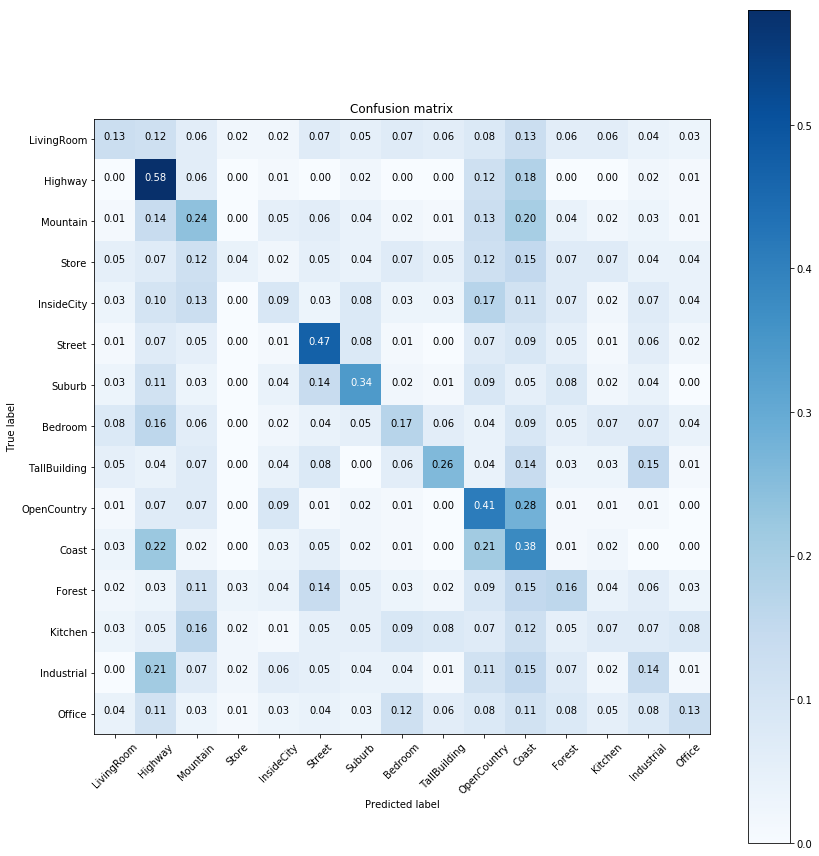

Confusion matrix for Q2
Normalized confusion matrix


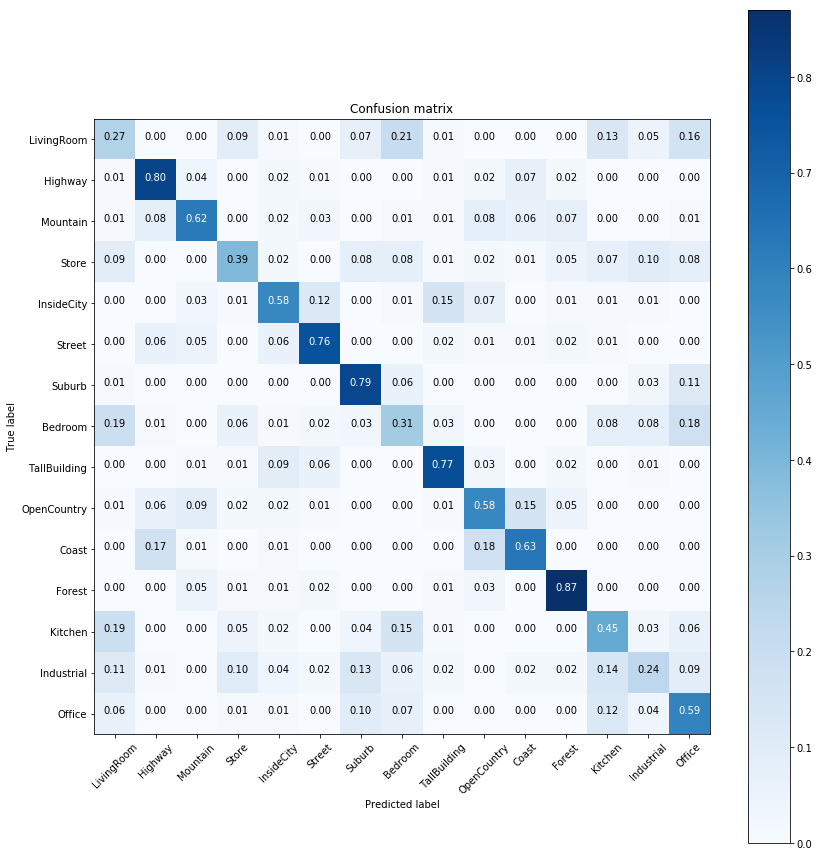

Confusion matrix for Q3
Normalized confusion matrix


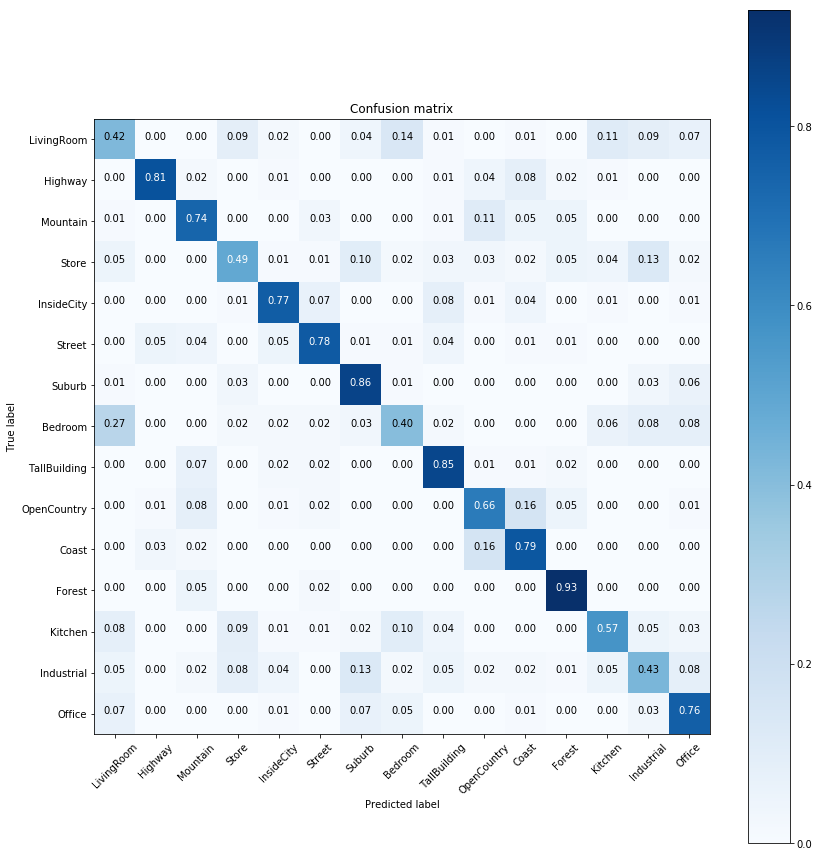

In [12]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
c_names = [name[11:] for name in glob.glob('data/train/*')]

#First combination:
# Confusion matrix
print("Confusion matrix for Q1")
cm1 = confusion_matrix(pred1, label1)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cm1, c_names, normalize=True)
plt.show()

#Second combination:
# Confusion matrix

print("Confusion matrix for Q2")
cm2 = confusion_matrix(pred2, label2)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cm2, c_names, normalize=True)
plt.show()

#Third combination:
# Confusion matrix

print("Confusion matrix for Q3")
cm3 = confusion_matrix(pred3, label3)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cm3, c_names, normalize=True)
plt.show()

## REPORT

**Hardware Details:-**<br>
Intel Core i7-6500U Processor (2.5GHz Base, up to 3.1GHz Turbo)<br>
RAM:- 16 GB<br>
Intel HD Graphics 520<br>


**First combination** (1st: Tiny images representation and nearest neighbor classifier): 

<i><h5> Time consumed and prediction accuracy:-</h5> </i>
<table class='table table-striped'> 
    <tr> 
        <th scope='row' style="text-align:center">Extracting tiny images</th> <th style="text-align:center">1.429 secs</th>
    </tr> 
    <tr> 
        <th scope='row' style="text-align:center">Training Nearest Neighbors</th> <th style="text-align:center">0.010 secs</th>
    </tr> 
     <tr> 
        <th scope='row' style="text-align:center">Testing and predicting labels </th> <th style="text-align:center">1.295 secs</th>
    </tr> 
</tbody> 
</table>
<table class='table table-striped'> 
    <tr> 
        <th scope='row' style="text-align:center">Prediction Accuracy</th> <th style="text-align:center">24.07%</th>
    </tr>  
</tbody> 
</table>



<i><h5> Algorithm descriptions and discussions</h5> </i>

     We are considering the "tiny image" feature based model as the baseline model. I have resized
     each image using resized_data(data) and reshaped it to 1*256 size vector. For normalizing the 
     image, to get zero mean and unit variance as described in the problem I have used StandardScaler()
     from "from sklearn.preprocessing import StandardScaler". I then created a 1500*256 size matrix that 
     represents feature matrix for training images and this data is fed to NearestNeighbor classifier 
     which is called by train(resized_train, resized_test, neighbors). I have used 1-NN method which 
     returns exactly one nearest neighbor for each test image. For predicting and testing I have used 
     predict(output, train_label, test_len) and test(nbrs). Before normalizing I got 22.60% accuracy
     after using StandardScaler() I was able to acheive 24.07% which shows that normalizing works 
     somewhat better. I have also used interpolation = cv2.INTER_AREA inside the resize function which
     showed some positive impact on accuracy, approximately 2%.

<i><h5> Confusion matrix observations </h5></i>

    Since the features with respect to tiny images don't represent very good information regarding
    an image, we can see that only Highways and Streets were identified pretty good while
    other class images performance was relatively very bad. Even OpenCountry and Coast is one such
    combination but though the identification was good but model was confused among the OpenCountry
    and Coast images. We can see that model performed worst for images of Store and Kitchen while model
    performed best for images of Highways. 
   
**Second combination** (2nd: Bag of SIFT representation and nearest neighbor - classifier ): <br>



 <i> <h5>Variations tried:</h5> </i>
<div class="tg-wrap"><table class='table table-striped'>
  <tr>
    <th>No. of clusters<br> (K-means)</th>
    <th>Step<br> (keyPoints)</th>
    <th>Scale<br> (keyPoints)</th>
    <th>Lambda(C) <br> (LinearSVC)</th>
    <th>Max_iter <br> (LinearSVC)</th>
    <th>Accuracy(%)<br> (For Q2)</th>
    <th>Accuracy(%)<br>(For Q3)</th>
  </tr>
  <tr>
    <td>100</td>
    <td>25</td>
    <td>20</td>
    <td>10</td>
    <td>100</td>
    <td>55.40</td>
    <td>65.20</td>
  </tr>
  <tr>
    <td>100</td>
    <td>50</td>
    <td>20</td>
    <td>10</td>
    <td>100</td>
    <td>52.07</td>
    <td>60.93</td>
  </tr>
  <tr>
    <td>100</td>
    <td>15</td>
    <td>20</td>
    <td>10</td>
    <td>100</td>
    <td>55.27</td>
    <td>66.20</td>
  </tr>
  <tr>
    <td>100</td>
    <td>30</td>
    <td>20</td>
    <td>10</td>
    <td>100</td>
    <td><span style="font-weight:bold">57.67%</span></td>
    <td>65.20</td>
  </tr>
  <tr>
    <td>200</td>
    <td>50</td>
    <td>20</td>
    <td>10</td>
    <td>100</td>
    <td>52.07</td>
    <td>64.13</td>
  </tr>
  <tr>
    <td>200</td>
    <td>25</td>
    <td>20</td>
    <td>10</td>
    <td>100</td>
    <td>54.73</td>
    <td>64.87</td>
  </tr>
  <tr>
    <td>500</td>
    <td>25</td>
    <td>20</td>
    <td>10</td>
    <td>100</td>
    <td>54.87</td>
    <td><span style="font-weight:bold">68.40</span></td>
  </tr>
</table></div>

<h6>Note:- </h6> Model File: bov_pickle_100_step_30_scale_20.sav is used for Q2 <br>
<h6>Note:- </h6> Model File: bov_pickle_500_step_25_scale_20.sav is used for Q3 <br>




 <i> <h5>Time consumed and prediction accuracy:</h5> </i>
<table class='table table-striped'> 
    <tr> 
        <th scope='row' style="text-align:center">Time for extracting training images descriptors
</th> <th style="text-align:center">322.627 secs</th>
    </tr> 
        <tr> 
        <th scope='row' style="text-align:center">Time for extracting test images descriptors</th> <th style="text-align:center">323.921 secs</th>
    </tr> 
        <tr> 
        <th scope='row' style="text-align:center">Time for training k-means(100)clusters</th> <th style="text-align:center">2605.883 secs</th>
    </tr> 
       <tr> 
        <th scope='row' style="text-align:center">Time for training NN classifier</th> <th style="text-align:center">0.006 secs</th>
    </tr> 
     <tr> 
        <th scope='row' style="text-align:center">Time for testing</th> <th style="text-align:center">0.412 secs</th>
    </tr> 
    <tr> 
        <th scope='row' style="text-align:center">Prediction Accuracy</th> <th style="text-align:center">57.67%</th>
    </tr> 
</tbody> 
</table>



<h6>Note:- </h6> Values given here are for the combination for which I got 57.67% <br>

 <i> <h5>Algorithm descriptions and discussions</h5> </i>
 
     Intially I have extracted keypoints for each training image and the extracted keypoints were 
     used to compute the descriptors. I used two approaches for extracting keypoints one was 
     row-wise (row, column) and another column wise (column , row) and I observed that
     (row, column) was performing better. Then, I have built a descriptor matrix of size (x,128) 
     where x is the number of extracted descriptors for all the training images. This step is 
     done similarly for test images. The descriptor matrix from training images is then fed to K-means
     clustering algorithm to get Bag of Visual Words whose number depends on the number of clusters selected 
     in the K-Means step. Once the clusters are found out each train image is selected and each 
     descriptor from that image is mapped to the cluster which it nearly represents. This process is
     repeated for all the descriptors for a particular training image and for each image we get a 
     histogram where each bins describes how many descriptors were mapped to it. Once the histogram
     is calculated, the histogram is normalized. This process is repeated for all the training images
     and a bigger histogram matrix is built by appending all such histograms into a single 
     matrix(train_hist of size 1500*(no_clusters)). This matrix is then fed to Nearest Neighbor 
     classifier(K=1) and a similar matrix is built for test images (test_hist). And then using
     the NN classifier model, we use test_hist as input for prediction and we predict the label 
     for each test image.  

 <i><h5>Confusion matrix observations </h5></i>
 
     Since more information from the images were extracted, we can see that the values for diagonal 
     elements is very much better than that of tiny image model. We see that the numbers for each 
     class have increased but still there is confusion among OpenCountry and Coast images. 
     We can see that model performed best for images of Forest and worst for images of Indutrial. 
     Model is also confused among images based on rooms like Kitchen, Office and Living Room.
     
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Third combination** (3rd: Bag of SIFT representation and linear SVM classifier): 

 <i><h5>Time consumed and prediction accuracy:</h5> </i>
<table class='table table-striped'> 
 <tr> 
        <th scope='row' style="text-align:center">Calculating histograms</th> <th style="text-align:center">12.761 secs</th>
    </tr> 
    <tr> 
        <th scope='row' style="text-align:center">Time for k-means(500)clusters</th> <th style="text-align:center">3631.452 secs</th>
    </tr> 
       <tr> 
    <tr> 
        <th scope='row' style="text-align:center">Training time</th> <th style="text-align:center">0.299 secs</th>
    </tr> 
     <tr> 
        <th scope='row' style="text-align:center">Testing time</th> <th style="text-align:center">0.003 secs</th>
    </tr> 
    <tr> 
        <th scope='row' style="text-align:center">Prediction Accuracy</th> <th style="text-align:center"> 68.40%</th>
    </tr> 
</tbody> 
</table>



<h6>Note:- </h6> Values given here are for the combination for which I got 68.40% <br>


 <i><h5>Algorithm descriptions and discussions </h5></i>
 
      Here we are using LinearSVC as classifier which internally uses multiple classifiers based on
      the number of output classes. The train_hist obtained from the second combination is used to 
      train the classifier while test_hist is used to predict labels. I have tried various values 
      for lambda or C parameter in LinearSVC 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10. 
      I have even tried various values for max_iter=100, 1000, 100000. The best combination 
      was C= 10 and max_iter = 100, hence only combination of this is shown in above table 
      while varying other parameters like step, scale and cluster size.
<i> <h5>Confusion matrix observations </h5></i>
    
    In this last method, where we have used LinearSVC we can see that almost all classes worked better 
    with good number relative to tiny image model as well as Bag of Words with NN. But the model is 
    still confused among Coast and OpenCountry images. There is also confusion among Kitchen, Living
    Room and Bedroom the reason could be that particular things that would be common for all rooms such 
    as drawers, lights, doors etc. This reason is applicable to above combinations too. The model 
    worked best for images of Forest and worst for images of Industrial/Bedroom. 

## Submission guidelines
---
Extract the downloaded .zip file to a folder of your preference. The input and output paths are predefined and **DO NOT** change them. The image read and write functions are already written for you. 

When submitting your .zip file through blackboard, please <br> 
-- name your .zip file as Surname_Givenname_SBUID (example: Trump_Donald_11113456). <br>
-- DO NOT change the folder structre, please just fill in the blanks. <br>

You are encouraged to make posts and answer questions on Piazza. Due to the amount of emails I receive from past years, it is unfortunate that I won't be able to reply all your emails. Please ask questions on Piazza and send emails only when it is private.

To encourage you to answer questions on piazza, the three persons answering the most questions will be awarded extra 5 points at the end of the semester.

If you alter the folder strucutres, the grading of your homework will be significantly delayed and possibly penalized. And I **WILL NOT** reply to any email regarding this matter.

Be aware that your codes will undergo plagiarism checker both vertically and horizontally. Please do your own work.

Late submission penalty: <br>
There will be a 10% penalty per day for late submission. However, you will have 3 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period. All late penalties incurred will be applied to your scores at the end of the semester.

Some important things to note: <br>
A correct pipeline for your submitted folder structure: <br>
1) Download the .zip file from blackboard and unzip it (e.g. CSE527-HW1-Fall18.zip) <br>
2) The unzipped folder should have name like CSE527-HW1-Fall18, rename it to Surname_Givenname_SBUID <br>
3) Write your codes in the given .ipynb file <br>
4) Save the visual outputs in the .ipynb file <br>
5) Rezip your Surname_Givenname_SBUID folder and submit <br>

**2 credits will be deducted** from HW2 and onwards if:
1) The unzipped folder still have name like CSE527-HW1-Fall18 <br>
2) There is a nested folder named CSE527-HW1-Fall18 under your Surname_Givenname_SBUID folder <br>
3) You zipped sub-folders and .ipynb directly without providing a root folder called Surname_Givenname_SBUID <br>
4) There are more than one .ipynb file under your folder (people who did this didn't receive a score for HW1) <br>
5) The naming didn't conform to Surname_Givenname_SBUID <br>
6) You didn't save the visual outputs inside your .ipynb file <br>